## Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import wrangle
import explore

## Acquire:

***
#### Web-Scraping GitHub with Beautiful Soup
***

***1. Identify HTML target feature using Beautiful Soup***

`Repo README.md text` - soup.select('article', class_="markdown-body entry-content container-lg")[0].text

`Repo primary language` - soup.select('li.d-inline:nth-child(1) > a:nth-child(1)')[0].text

***2. Code extraction functions used to create corpus***

`def get_soup()`
This function takes in a URL, parses the HTML and returns a BeautifulSoup object

`def gethub_geology_urls()`
This function returns a list of URLs that can be read in the get_readme_articles() function

`def get_geo_results()`
This function scrapes and returns a list of repo URLs from search results

#### Explanation:

Using the python library, Beautiful Soup, the README.md text of 507 GitHub repositories were scraped. I focused my search exclusively on repositories identifed by the keyword'Geology'. The results of this scrape were saved in a json file and were used as our research corpus.

## Prepare:

In [2]:
# def prep_data(df, column):
#     df['content_clean'] = df[column].apply(basic_clean)\
#                                     .apply(tokenize)\
#                                     .apply(lemmatize)\
#                                     .apply(remove_stopwords)\
#                                     .apply(remove_extra_words)

#     # add a column with a list of words
#     words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.content_clean]

#     # column name will be words, and the column will contain lists of the words in each doc
#     df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

#     # add column with number of words in readme content
#     df['doc_length'] = [len(wordlist) for wordlist in df.words]
    
#     # Adds column with bigrams and trigrams
#     df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
#     df['trigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.trigrams(row.split(' '))))
    
#     # Specify dataframe content
#     df = df[['language','content','content_clean','doc_length','words','bigrams','trigrams']]
#     return df


#### Explanation:

`basic_clean( ):` This function changes the text to lowercase, removes special characters, encodes to ascii and recode to utf-8 to remove numbers from the text, and finally replaces anything that is not a letter, number, whitespace, or a single quote with an empty string. 

`tokenize( ):` This function takes in a string and returns that string broken up in to a list of individual words.

`lemmatize( ):` This function takes in string for and returns a string with words simplified to dictionary roots.

`remove_stopwords():` This function is a spealized cleaning tool from the Gensim library that cleans and parses 
                      text for topic modeling and removes more common words then the traditional nltk library.

#### Natural Language ToolKit (NLTK)

-NLTK library has 179 words in the stopword collection.

Note: All the words in the default library’s stopword list are in lower case, that means documents/sentences words also must be lower case. Otherwise, stopword not got removed from your data.

In [3]:
from nltk.corpus import stopwords
nltk_stopwords = set(stopwords.words('english'))
text = f"The first time I saw Catherine she was wearing a vivid crimson dress and was nervously " \
f"leafing through a magazine in my waiting room."
text_without_stopword = [word for word in text.split() if word.lower() not in nltk_stopwords]
print(f"Original Text : {text}")
print(f"Text without stopwords : {' '.join(text_without_stopword)}")
print(f"Total count of stopwords in NLTK is {len(nltk_stopwords)}")

Original Text : The first time I saw Catherine she was wearing a vivid crimson dress and was nervously leafing through a magazine in my waiting room.
Text without stopwords : first time saw Catherine wearing vivid crimson dress nervously leafing magazine waiting room.
Total count of stopwords in NLTK is 179


#### Gensim Library

-Gensim has 337 words in their stopwords collection

Note: 

In [4]:
from gensim.parsing.preprocessing import remove_stopwords
import gensim

gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS

text = f"The first time I saw Catherine she was wearing a vivid crimson dress and was nervously " \
       f"leafing through a magazine in my waiting room."

print(f"Original Text : {text}")
print(f"Text without stopwords : {remove_stopwords(text.lower())}")
print(f"Total count of stopwords in Ginsim is {len(gensim_stopwords)}")

Original Text : The first time I saw Catherine she was wearing a vivid crimson dress and was nervously leafing through a magazine in my waiting room.
Text without stopwords : time saw catherine wearing vivid crimson dress nervously leafing magazine waiting room.
Total count of stopwords in Ginsim is 337


## Data Exploration: (Topic Modeling)

1. Create list of words using feature extraction
2. Apply LDA
3. Use LDA to predict (n) Topics
4. Explore topics for correlations
5. Repeat and fine tune model parameters

#### Call in Clean Data Frame

In [5]:
df = wrangle.get_geo_results(cached=True)
df = wrangle.prep_data(df, 'content')
df.head()

,language,content,content_clean,doc_length,words,bigrams,trigrams
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,map merger tool tested arcmap written ryan cro...,38,"[map, merger, tool, tested, arcmap, written, r...","[(map, merger), (merger, tool), (tool, tested)...","[(map, merger, tool), (merger, tool, tested), ..."
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs javascript converting welllog standar...,1053,"[welliojs, javascript, converting, welllog, st...","[(welliojs, javascript), (javascript, converti...","[(welliojs, javascript, converting), (javascri..."
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d web version geologica...,152,"[geomodeldweb, generatesweb, version, geologic...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ..."
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature geological feature quanfock hill de...,166,"[geofeature, geological, feature, quanfock, hi...","[(geofeature, geological), (geological, featur...","[(geofeature, geological, feature), (geologica..."
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u geological survey best practice repository h...,13,"[u, geological, survey, best, practice, reposi...","[(u, geological), (geological, survey), (surve...","[(u, geological, survey), (geological, survey,..."


### Topic Modeling: Step One (Creating a list of Words using Feature Extraction)

- Before we can apply LDA, we need to create vocabulary of all the words in our data. We do so with the help of a count vectorizer.   


- sklearn.feature_extraction.text module to create a document-term matrix. We specify to only include those words that appear in less than 80% of the document and appear in at least 2 documents. We also remove all the stop words as they do not really contribute to topic modeling.   

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df['content_clean'].values.astype('U'))
doc_term_matrix

<507x5159 sparse matrix of type '<class 'numpy.int64'>'
	with 39279 stored elements in Compressed Sparse Row format>

**Each of 507 documents is represented as 5159 dimensional vector, which means that our `corpus has 5159 words.`**
***

### Topic Modeling: Step Two (Applying LDA)

- We next use LatentDirichletAllocation class from the sklearn.decomposition library to perform LDA on our document-term matrix. The parameter n_components specifies the number of categories, or topics, that we want our text to be divided into. The parameter random_state (aka the seed) is set to 123 so that you get similar results each time.


- Let's verify it word by randomly fetching words from our vocabulary. We can use the get_feature_names() method and pass it the ID of the word that we want to fetch.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [8]:
# 10 random words
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

grab
legacy
conveniently
libadaptiviy
choice
accurate
zoom
constrained
ph
yellow


***
### Topic Modeling: Step Three (Review Groups and Append to Data Frame)

- Using the components_ attribute from LDA we use the argsort() function to sort the (n) number of words with the hightest probaiity of being associated with each of the five topics.  If these groups make sense, we can append them to to the dataframe. 


In [9]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['source', 'book', 'software', 'repository', 'license', 'project', 'report', 'data', 'enabled', 'file']


Top 10 words for topic #1:
['start', 'project', 'code', 'use', 'app', 'npm', 'build', 'test', 'run', 'file']


Top 10 words for topic #2:
['mesh', 'project', 'file', 'run', 'data', 'task', 'example', 'geomodeller', 'model', 'geology']


Top 10 words for topic #3:
['use', 'text', 'field', 'geologic', 'feature', 'geological', 'model', 'file', 'map', 'data']


Top 10 words for topic #4:
['pip', 'information', 'file', 'usgs', 'map', 'set', 'python', 'install', 'earthquake', 'data']




- As a final step, we will add a column to the original data frame that will store the topic for the text. To do so, we can use LDA.transform() method and pass it our document-term matrix. This method will assign the probability of all the topics to each document.

In [10]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(507, 5)

- The output (507, 5) lets us know that each of the document have been sorted in to 5 groups where each group corresponds to the probability value of a particular topic. Finally we will add a new column for topic in the data frame and assigns the topic value to each row in the column.


In [11]:
df['topic'] = topic_values.argmax(axis=1)
df.head()

,language,content,content_clean,doc_length,words,bigrams,trigrams,topic
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,map merger tool tested arcmap written ryan cro...,38,"[map, merger, tool, tested, arcmap, written, r...","[(map, merger), (merger, tool), (tool, tested)...","[(map, merger, tool), (merger, tool, tested), ...",0
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs javascript converting welllog standar...,1053,"[welliojs, javascript, converting, welllog, st...","[(welliojs, javascript), (javascript, converti...","[(welliojs, javascript, converting), (javascri...",3
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d web version geologica...,152,"[geomodeldweb, generatesweb, version, geologic...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",4
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature geological feature quanfock hill de...,166,"[geofeature, geological, feature, quanfock, hi...","[(geofeature, geological), (geological, featur...","[(geofeature, geological, feature), (geologica...",0
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u geological survey best practice repository h...,13,"[u, geological, survey, best, practice, reposi...","[(u, geological), (geological, survey), (surve...","[(u, geological, survey), (geological, survey,...",0


***
## Topic Modeling: Step Four (Explore topics for correlations)

- Wordcount List

- Poroprtion Visuliazation

- Wordclouds

### Call in df

In [12]:

df1 = wrangle.get_geo_results(cached=True)
df1 = wrangle.prep_data(df1, 'content')
df1 = explore.nlp_topic_modeling(df1, max_df = 0.8 , min_df = 2 , n_components = 5)
df1.head()

Top 5 words for topic #0:
['geological', 'usgs', 'text', 'report', 'set', 'project', 'earthquake', 'file', 'map', 'data']


Top 5 words for topic #1:
['example', 'code', 'geological', 'geology', 'version', 'python', 'run', 'model', 'data', 'file']


Top 5 words for topic #2:
['line', 'package', 'notebook', 'powerlaw', 'exercise', 'deposit', 'pip', 'conda', 'python', 'install']


Top 5 words for topic #3:
['code', 'app', 'project', 'npm', 'test', 'build', 'use', 'run', 'file', 'enabled']


Top 5 words for topic #4:
['earthquake', 'usgs', 'file', 'build', 'use', 'geological', 'project', 'app', 'android', 'license']




,language,content,content_clean,doc_length,words,bigrams,trigrams,topic
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,map merger tool tested arcmap written ryan cro...,38,"[map, merger, tool, tested, arcmap, written, r...","[(map, merger), (merger, tool), (tool, tested)...","[(map, merger, tool), (merger, tool, tested), ...",4
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs javascript converting welllog standar...,1053,"[welliojs, javascript, converting, welllog, st...","[(welliojs, javascript), (javascript, converti...","[(welliojs, javascript, converting), (javascri...",0
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d web version geologica...,152,"[geomodeldweb, generatesweb, version, geologic...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",4
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature geological feature quanfock hill de...,166,"[geofeature, geological, feature, quanfock, hi...","[(geofeature, geological), (geological, featur...","[(geofeature, geological, feature), (geologica...",2
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u geological survey best practice repository h...,13,"[u, geological, survey, best, practice, reposi...","[(u, geological), (geological, survey), (surve...","[(u, geological, survey), (geological, survey,...",0


In [13]:
# combine list of word counts into df for further exploration

# create a list of words for each language category and remove single letter words
t0_words,t1_words,t2_words,t3_words,t4_words = explore.create_lang_word_list(df1)

# get the count of words by category
t0_freq, t1_freq, t2_freq, t3_freq, t4_freq = explore.get_count_word_freq(t0_words,t1_words,t2_words,t3_words,t4_words)

# combine list of word counts into df for further exploration
word_counts = explore.create_df_word_counts(t0_freq, t1_freq, t2_freq, t3_freq, t4_freq)
word_counts = explore.word_counts_proportion(word_counts)
word_counts

,t0,t1,t2,t3,t4,all_words,prop_t0,prop_t1,prop_t2,prop_t3,prop_t4
&#9;,149,7,65,1,12,234,0.636752,0.029915,0.277778,0.004274,0.051282
&#9;dtm,0,0,4,0,0,4,0.000000,0.000000,1.000000,0.000000,0.000000
&#9;dtm&#9;,0,0,2,0,0,2,0.000000,0.000000,1.000000,0.000000,0.000000
&#9;expressed,1,0,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000
&#9;geological,1,0,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
zurich,1,0,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000
zusammenfassung,0,0,0,0,1,1,0.000000,0.000000,0.000000,0.000000,1.000000
zwischen,0,0,0,0,2,2,0.000000,0.000000,0.000000,0.000000,1.000000
zwrocic,0,0,1,0,0,1,0.000000,0.000000,1.000000,0.000000,0.000000


<Figure size 864x576 with 0 Axes>

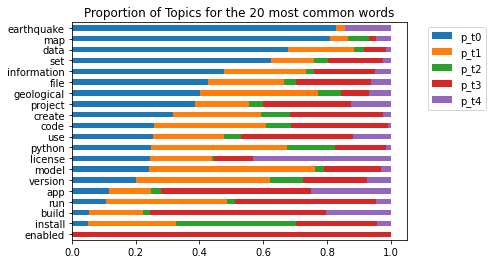

In [14]:
explore.proportion_visualization(word_counts)

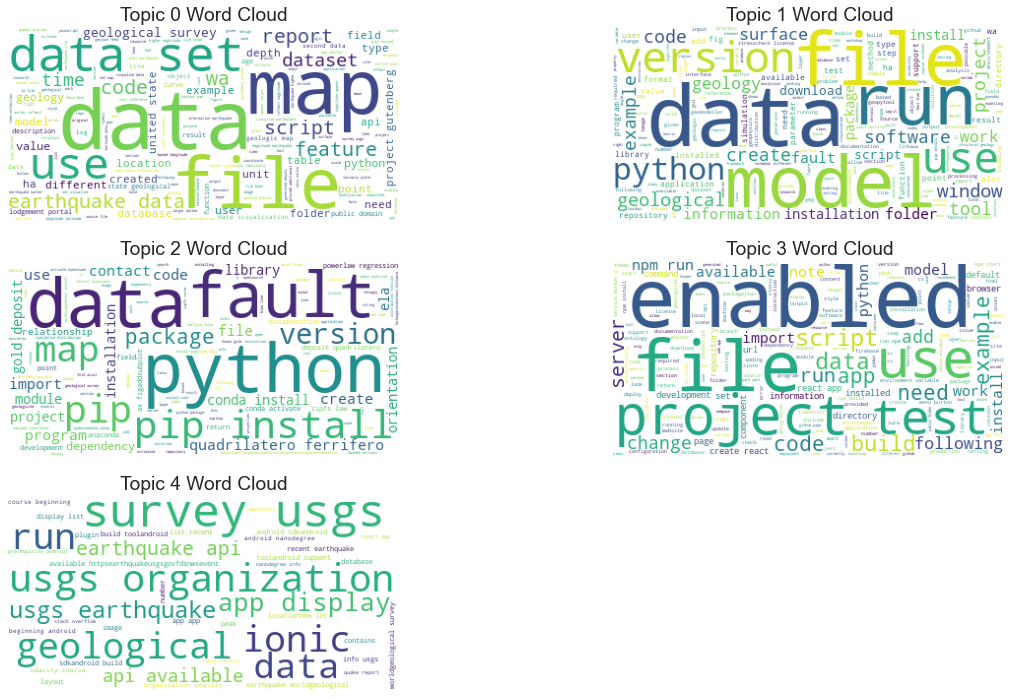

In [15]:
explore.plot_wordcloud(df1)

**Takeaway:**

`Some peliminary differences are visible, however common words block clear trends`

- To clean up corpus must remove common words (non-Geology)
- Remove repository in Spannish (TypeScript)
***

### Topic Modeling: Step Five (Fine Tune Model Parameters)

- Remove additional non content specific common words **(~800)**

- Run through the modeling process a second time to fine tune results 

In [16]:
df2 = wrangle.get_geo_results(cached=True)
df2 = wrangle.prep_data_extra_words(df2, 'content')
df2.head()

,language,content,content_clean,doc_length,words,bigrams,trigrams
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,merger tested arcmap written ryan crow usgs ai...,22,"[merger, tested, arcmap, written, ryan, crow, ...","[(merger, tested), (tested, arcmap), (arcmap, ...","[(merger, tested, arcmap), (tested, arcmap, wr..."
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs converting welllog standard isn ' t p...,526,"[welliojs, converting, welllog, standard, isnt...","[(welliojs, converting), (converting, welllog)...","[(welliojs, converting, welllog), (converting,..."
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d primarily geomodelpor...,89,"[geomodeldweb, generatesprimarily, geomodelpor...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ..."
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature quanfock hill demo httpsgeoffrowlan...,98,"[geofeature, quanfock, hill, demo, httpsgeoffr...","[(geofeature, quanfock), (quanfock, hill), (hi...","[(geofeature, quanfock, hill), (quanfock, hill..."
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u best practice largely superseded usgs manage...,7,"[u, best, practice, largely, superseded, usgs,...","[(u, best), (best, practice), (practice, large...","[(u, best, practice), (best, practice, largely..."


### Apply Topic Modeling to New Corpus

In [17]:
df2 = explore.nlp_topic_modeling(df2, max_df = 0.8 , min_df = 2 , n_components = 5)
df2.head()

Top 5 words for topic #0:
['day', 'united', 'menu', 'depth', 'layer', 'log', 'state', 'magnitude', 'usgs', 'earthquake']


Top 5 words for topic #1:
['rank', 'analytical', 'stress', 'geomodeller', 'element', 'seismic', 'powerlaw', 'surface', 'fault', 'deposit']


Top 5 words for topic #2:
['symbol', 'consideration', 'date', 'layer', 'special', 'water', 'myenvname', 'ela', 'age', 'field']


Top 5 words for topic #3:
['borehole', 'profile', 'archive', 'digital', 'item', 'ontology', 'collection', 'ebooks', 'gitenberg', 'gutenberg']


Top 5 words for topic #4:
['iv', 'distributed', 'adding', 'deploy', 'edit', 'projection', 'cs', 'usgs', 'ionic', 'formation']




,language,content,content_clean,doc_length,words,bigrams,trigrams,topic
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,merger tested arcmap written ryan crow usgs ai...,22,"[merger, tested, arcmap, written, ryan, crow, ...","[(merger, tested), (tested, arcmap), (arcmap, ...","[(merger, tested, arcmap), (tested, arcmap, wr...",0
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs converting welllog standard isn ' t p...,526,"[welliojs, converting, welllog, standard, isnt...","[(welliojs, converting), (converting, welllog)...","[(welliojs, converting, welllog), (converting,...",0
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d primarily geomodelpor...,89,"[geomodeldweb, generatesprimarily, geomodelpor...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",2
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature quanfock hill demo httpsgeoffrowlan...,98,"[geofeature, quanfock, hill, demo, httpsgeoffr...","[(geofeature, quanfock), (quanfock, hill), (hi...","[(geofeature, quanfock, hill), (quanfock, hill...",2
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u best practice largely superseded usgs manage...,7,"[u, best, practice, largely, superseded, usgs,...","[(u, best), (best, practice), (practice, large...","[(u, best, practice), (best, practice, largely...",3


### Explore Topics 

In [18]:
# combine list of word counts into df for further exploration

# create a list of words for each language category and remove single letter words
t0_words,t1_words,t2_words,t3_words,t4_words = explore.create_lang_word_list(df2)

# get the count of words by category
t0_freq, t1_freq, t2_freq, t3_freq, t4_freq = explore.get_count_word_freq(t0_words,t1_words,t2_words,t3_words,t4_words)

# combine list of word counts into df for further exploration
word_counts = explore.create_df_word_counts(t0_freq, t1_freq, t2_freq, t3_freq, t4_freq)
word_counts = explore.word_counts_proportion(word_counts)
word_counts

,t0,t1,t2,t3,t4,all_words,prop_t0,prop_t1,prop_t2,prop_t3,prop_t4
aapgexamples,1,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
aardvark,0,0,0,2,0,2,0.0,0.0,0.0,1.0,0.0
aba,0,1,0,0,0,1,0.0,1.0,0.0,0.0,0.0
abandoned,1,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
abandonment,0,0,2,0,0,2,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
zurich,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0
zusammenfassung,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0
zwischen,0,0,0,2,0,2,0.0,0.0,0.0,1.0,0.0
zwrocic,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0


<Figure size 864x576 with 0 Axes>

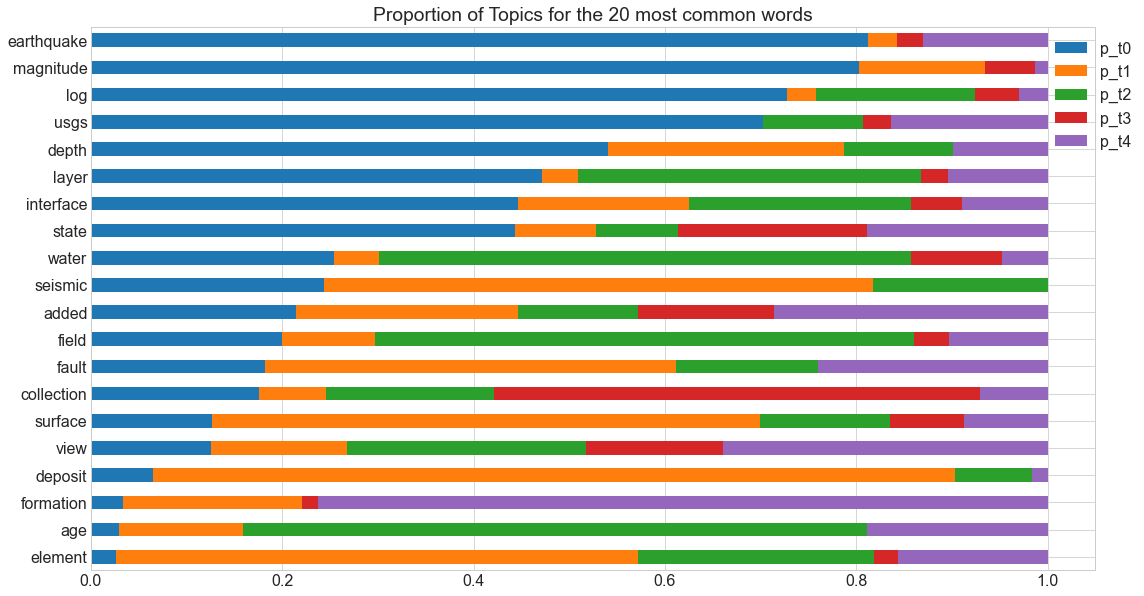

In [19]:
# visualize the % of the term in each language
explore.proportion_visualization(word_counts)

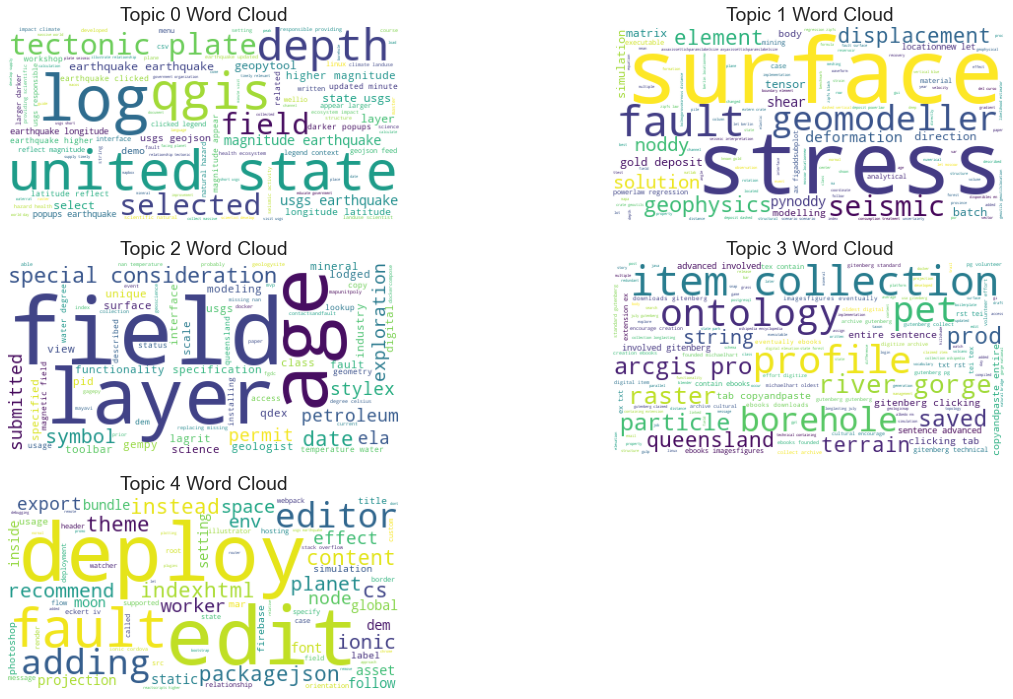

In [20]:
explore.plot_wordcloud(df2)